# Gaussian Mixture Model and the EM Algorithm

![Image](imgs/mixture.png)

This script shows how the *Expectation-Maximaisation (EM) Algorithm* can be used to recover the means and covariance matrices from data which is assumed to be generated by a Gaussian-mixture model. 

## Core Problem From a Learning Perspective

The core of problem is that we observe data points $x_i$, but we are not given from which Gaussian they came from. We assume that the data arose from a Gaussian-mixture model, and by using the EM Algorithm, we are able to give predictions for the means of the Gaussians, the mixing coefficients, and the covariance matrices. Thus, the only parameter that we set is the number of Gaussians $k$ which is why the EM algorithm is an example of *unsupervised learning*. We could extend our model to its hierarchical version to infer $k$ itself from the data. However, this is not part of this script.

## Why Normal Inference Is not Feasible

Let $X$ be the data we obverve, $Z$ the latent variables of our model, and $\theta$ the model parameters. In the case of the Gaussian-mixture, $Z = \{z_i\}_i$ describe from which Gaussian the data point $x_i$ came. Further, we assume that $\ln{p(X, Z|\theta}$ has a simple, closed form because we choose our model $p(X, Z|\theta)$ to be from the exponential family. In order to find good $\theta$, we try to maximise the **data log-likelihood** $$\ln{p(X, Z|\theta}) = \ln{\prod_i p(x_i, z_i|\theta)} = \sum_i \ln{p(x_i, z_i|\theta)}$$. However, we do not observe $Z$. Thus, the data log-likelihood can be expressed as $$\ln{p(X|\theta)} = \ln{\sum_{z_k} p(X, z_k|\theta)} = \sum_{x_i} \ln{\sum_{z_k} p(x_i, z_k | \theta)} $$ which has no closed form and cannot be calculated in general. The main reason is that we have a sum inside the logarithm.

## Idea of the ME Algorithm

Instead of using the marginal distribution over $X$, we simplify our approach to maximise the *expected* log-likelihood $p(X, Z| \theta)$ if we assume $Z$ is distributed according to its posterior probability $p(Z|X, \theta)$: $$\theta^{max} = \text{argmax}_{\theta_i} \mathbb{E}_{Z|X, \theta_i}[\ln{p(X, Z| \theta_i)}] = \text{argmax}_{\theta_i} \sum_{z_k} p(z_k|X, \theta_i) \ln{\prod_{x_i} p(x_i, z_k| \theta)} = \text{argmax}_{\theta_i} \sum_{z_k} p(z_k|X, \theta_i) \sum_{x_i} \ln{ p(x_i, z_k| \theta)}$$
The two steps of the algorithm are then 
1. The E-step: We calculate the expected log-likelihood as a function of $\theta$: $Q(\theta, \theta_{\text{old}}) = \sum_{z_k} p(z_k|X, \theta_{\text{old}}) \ln{p(X, z_k | \theta)}$
2. The M-step: We choose our new $\theta$ as the one which maximises the expectation: $\theta^{\text{new}} = \text{argmax}_{\theta} Q(\theta_\text{old}, \theta)$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
%matplotlib inline

In [2]:
def generate_mixing_coefficients(number):
    a = 1
    pi_v = np.zeros(number)
    for i in range(number-1):
        pi_v[i] = np.random.uniform(0, a)
        a = a - pi_v[i]
    pi_v[number-1] = a
    return pi_v

num_gaussian = 3
pi_v = generate_mixing_coefficients(num_gaussian)
sigma_v = np.zeros((num_gaussian,2,2))
sigma_v[:, 0, 0] = np.random.uniform(1, 4, size=num_gaussian)
sigma_v[:, 1, 1] = np.random.uniform(1, 4, size=num_gaussian)
sigma_v[:, 0, 1] = np.random.normal(0, 1, size=num_gaussian)
sigma_v[:, 1, 0] = sigma_v[:, 0, 1]

mean_v = np.random.uniform(-20, 20, size=(num_gaussian, 2))

Now, we can draw samples from the mixture of Gaussians by executing the following procedure for each sample:
1. Draw $\pi_k$ from the Categorical distribution conditioned on the vector $\mathbf{\pi_v}$ which are the mixing coefficients
2. Draw a sample x from the k-th Gaussian, $x \sim \mathcal{N}(\mu_k,\,\Sigma_k)$ 

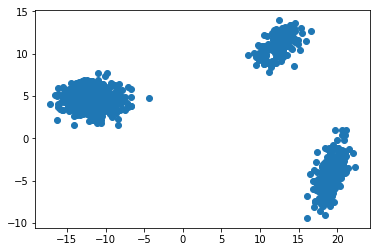

In [3]:
num_samples = 1000
samples = np.zeros((num_samples, 2))
p = np.random.multinomial(num_samples, pi_v)
samples[:p[0],:] = np.random.multivariate_normal(mean_v[0], sigma_v[0], size=p[0])
for i in range(1, num_gaussian, 1):
    samples[np.sum(p[:i]):np.sum(p[:i+1]),:] = np.random.multivariate_normal(mean_v[i], sigma_v[i], size=p[i])
plt.scatter(samples[:, 0], samples[:, 1])

## EM Algorithm

We only use our set of samples and use the EM algorithm to recover the mixing coefficients, covariance matrices, and means of the set of Gaussians.

In [4]:
# First, we initialise the values
mean_em = samples[np.random.randint(low=0, high=num_samples, size=num_gaussian),:]
sigma_em = np.array([np.identity(2)]*num_gaussian)
pi_em = np.zeros(num_gaussian)
a = 1
for i in range(num_gaussian-1):
    pi_em[i] = np.random.uniform(0, a)
    a -= pi_em[i]
pi_em[num_gaussian-1] = a
gamma = np.zeros((num_samples, num_gaussian))

In [5]:
def log_likelihood(x, mean_em, sigma_em, pi_em):
    s = np.sum([np.log(np.sum([pi_em[k]*multivariate_normal.pdf(x_i, mean=mean_em[k,:], cov=sigma_em[k,:,:]) for k in range(num_gaussian)])) for x_i in x])
    return s

In [6]:
epo = 1
log_l = np.array([log_likelihood(samples, mean_em, sigma_em, pi_em)])
dif = 100
while (dif > 0.5 or epo>30):
    # E step
    for n in range(num_samples):
        s = np.sum([pi_em[k]*multivariate_normal.pdf(samples[n,:], mean=mean_em[k,:], cov=sigma_em[k,:,:]) for k in range(num_gaussian)])
        for k in range(num_gaussian):
            gamma[n, k] = pi_em[k]*multivariate_normal.pdf(samples[n,:], mean=mean_em[k,:], cov=sigma_em[k,:,:])/s
            
    # M Step
    N_k = [np.sum([gamma[n, k] for n in range(num_samples)]) for k in range(num_gaussian)]
    mean_em = np.array([np.sum([gamma[n, k]*samples[n,:] for n in range(num_samples)], axis=0)/N_k[k] for k in range(num_gaussian)])
    sigma_em = np.array([np.sum([gamma[n,k]*np.outer(samples[n,:]-mean_em[k,:], samples[n,:]-mean_em[k,:]) for n in range(num_samples)], axis=0)/N_k[k] for k in range(num_gaussian)])
    pi_em = np.array([N_k[k]/num_samples for k in range(num_gaussian)])
    
    # Check Convergence criterium
    log_l = np.append(log_l, log_likelihood(samples, mean_em, sigma_em, pi_em))
    dif = log_l[len(log_l)-1] - log_l[-2:-1]
    print("Run", epo, 'done with log likelihood:', log_l[len(log_l)-1])
    epo += 1



Run 1 done with log likelihood: -4896.301849852564
Run 2 done with log likelihood: -4786.182802130799
Run 3 done with log likelihood: -4693.406042004201
Run 4 done with log likelihood: -4638.01701895471
Run 5 done with log likelihood: -4592.61582816721
Run 6 done with log likelihood: -4510.748983242431
Run 7 done with log likelihood: -4407.683905334685
Run 8 done with log likelihood: -4407.662407303662


## Results

Let's have a look at the means and covariances that the EM-algorithm recovered (in red).

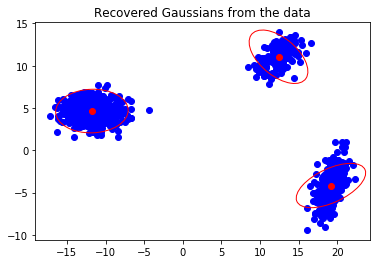

In [7]:
eigen_v = [np.linalg.eig(sigma_em[k, :, :]) for k in range(num_gaussian)]
ab = np.array([2*np.sqrt(5.99*eigen_v[k][0]) for k in range(num_gaussian)])
max_ev = [np.argmax(ab[k], axis=0) for k in range(num_gaussian)]
ang = [np.degrees(np.arctan(eigen_v[k][1][max_ev[k]][1]/eigen_v[k][1][max_ev[k]][0])) for k in range(num_gaussian)]

plt.figure()
ax = plt.gca()
plt.scatter(samples[:,0],samples[:,1],color='blue')
plt.scatter(mean_em[:,0], mean_em[:,1],color='red')
for k in range(num_gaussian):
    ellipse = Ellipse(mean_em[k,:], ab[k][0], ab[k][1], angle=ang[k], facecolor='none', edgecolor='red')
    ax.add_patch(ellipse)

plt.title('Recovered Gaussians from the data')
plt.show()